In [28]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.models import load_model
from keras.models import model_from_yaml
import pickle

In [29]:
path= "dataset"
mylist= os.listdir(path)
print("Total classes detected: ",len(mylist))
no_classes= len(mylist)

Total classes detected:  10


In [30]:
count= 0
images= []
class_number= []

print("importing the classes........")
for x in range(0, no_classes):
    myPicklist= os.listdir(path + "/"+str(x))
    for y in myPicklist:
        size_image= cv2.imread(path+"/"+str(x)+"/"+y)
        size_image= cv2.resize(size_image,(32,32))
        images.append(size_image)
        class_number.append(x)
    print(x, end= " , ")

importing the classes........
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

In [31]:
images= np.array(images)
class_number= np.array(class_number)

print(images.shape)
print(class_number.shape)

(10160, 32, 32, 3)
(10160,)


In [32]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(images, class_number, test_size= 0.2)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size= 0.2)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)


[643, 648, 638, 648, 629, 666, 660, 677, 632, 661]


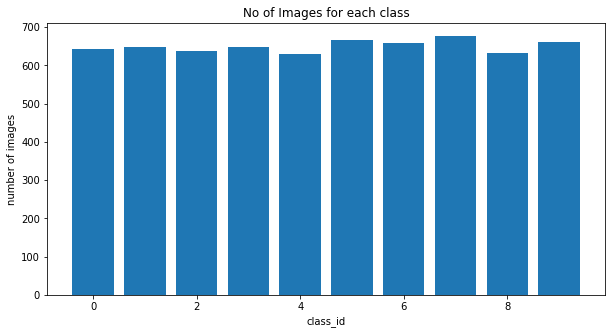

In [33]:
no_samples= []

for x in range(0, no_classes):
    no_samples.append(len(np.where(y_train==x)[0]))
print(no_samples)

plt.figure(figsize= (10,5))
plt.bar(range(0,no_classes), no_samples)
plt.title("No of Images for each class")
plt.xlabel("class_id")
plt.ylabel("number of images")
plt.show()

In [34]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

# img= preProcessing(x_train[30])
# img= cv2.resize(img, (200,200))
# cv2.imshow("Preprocessed", img)

In [35]:
x_train= np.array(list(map(preProcessing,x_train)))
x_test= np.array(list(map(preProcessing,x_test)))
x_validation= np.array(list(map(preProcessing,x_validation)))
 

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_validation = x_validation.reshape(x_validation.shape[0],x_validation.shape[1],x_validation.shape[2],1)
 
#### IMAGE AUGMENTATION 
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(x_train)

In [36]:
y_train= to_categorical(y_train, no_classes)
y_test= to_categorical(y_test, no_classes)
y_validation= to_categorical(y_validation, no_classes)

In [37]:
imageDimensions= (32,32,3)

#### CREATING THE MODEL 
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500
 
    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_classes, activation='softmax'))
 
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
 
model = myModel()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 30)         

Epoch 1/12
100/100 [==============================] - 11s 110ms/step - loss: 2.0369 - accuracy: 0.2394 - val_loss: 0.8469 - val_accuracy: 0.7768
Epoch 2/12
100/100 [==============================] - 11s 108ms/step - loss: 0.9637 - accuracy: 0.6794 - val_loss: 0.1994 - val_accuracy: 0.9360
Epoch 3/12
100/100 [==============================] - 11s 108ms/step - loss: 0.6013 - accuracy: 0.8050 - val_loss: 0.1741 - val_accuracy: 0.9379
Epoch 4/12
100/100 [==============================] - 11s 108ms/step - loss: 0.4824 - accuracy: 0.8456 - val_loss: 0.1129 - val_accuracy: 0.9649
Epoch 5/12
100/100 [==============================] - 11s 108ms/step - loss: 0.3738 - accuracy: 0.8811 - val_loss: 0.1373 - val_accuracy: 0.9588
Epoch 6/12
100/100 [==============================] - 11s 108ms/step - loss: 0.3436 - accuracy: 0.8956 - val_loss: 0.0916 - val_accuracy: 0.9692
Epoch 7/12
100/100 [==============================] - 11s 110ms/step - loss: 0.3137 - accuracy: 0.9056 - val_loss: 0.0933 - val_ac

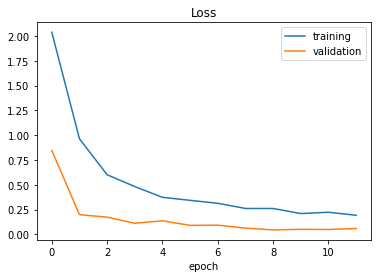

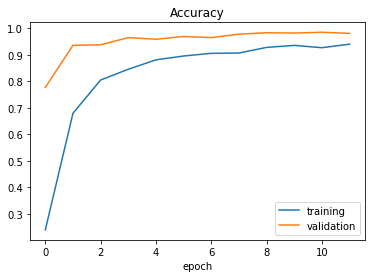

Test Score =  0.073676697909832
Test Accuracy = 0.9709645509719849


In [38]:
batchSizeVal= 16
stepsPerEpochVal = 100
epochsVal = 12

#### STARTING THE TRAINING PROCESS
history = model.fit_generator(dataGen.flow(x_train,y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpochVal,
                                 epochs=epochsVal,
                                 validation_data=(x_validation,y_validation),
                                 shuffle=1)
 
#### PLOT THE RESULTS  
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#### EVALUATE USING TEST IMAGES
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])


In [39]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
